In [43]:
import numpy as np
import powerlaw
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 150

/var/folders/77/jfwlc7mn17nftm69gps4bk640000gn/T/ipykernel_8230/1719089161.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [44]:
# establish the dataset
d = 500 # dimension
k = 4 # sparsity
n = 1200 # sample size
K = 400 # number of subgroups
# TODO plot a graph with K as x axis and y as performance
p = 0.1 # corruption probability
mu = np.zeros(d)
mu_sparse = [20, -10, -5, 2]
mu[:k] = mu_sparse
mu = mu.reshape((d, 1))

setting = 'powerlaw'
distribution = 'powerlaw'
X = np.empty((n, d))

match distribution:
    case 'normal':
        # normal distribution
        X = np.random.normal(0, 1, size=(n, d))
    case 'powerlaw':
        # power law distribution
        alpha = 2.5
        xmin = 1
        mean = np.zeros((n, d))
        mean += (alpha / (alpha - 1)) * xmin
        dist = powerlaw.Power_Law(xmin=xmin, parameters=[alpha])
        for i in range(n):
            X[i, :] = dist.generate_random(d)
        X = X - mean
        print(X[0])


for i in range(k):
    X[:, i] += mu_sparse[i]

# print(np.mean(X, axis=0))

# Add corrupted data
for j in range(np.floor(p * n).astype(int)):
    X[j, :] = 20 + 50 * np.random.standard_cauchy(size=(1, d)) # non-standard Cauchy, mean 20, scale 50
# print(np.mean(X, axis=0))

# Grouping preprocessing
X_grouped = np.split(X, K)
X_grouped = np.mean(X_grouped, axis=1)

# print(len(X_grouped))

[-7.15277903e-02 -4.36495395e-01  2.86475694e-02 -1.22604954e-01
  3.16546117e-01 -6.62663042e-01 -5.46121884e-01  9.81352740e-01
 -3.88964368e-01 -4.76966061e-01 -2.31605088e-01  3.71165916e+00
  1.40415909e-01 -4.13713572e-01 -5.39583857e-01 -6.30068535e-01
 -6.58781041e-01 -5.01505251e-01  8.62420913e-01  8.16140813e+00
 -2.15158845e-01 -2.11831531e-01 -4.24472093e-01  7.51424898e-02
  4.55108776e+00  2.77330737e-01 -6.56513467e-01 -6.49084235e-01
  2.65933298e+00  6.24918132e-01  9.63411101e+00  3.54535070e-01
 -2.86223674e-01 -2.10021625e-02 -4.86643426e-01 -1.87149384e-01
  2.71552942e-01 -6.27442971e-01 -2.96791391e-01  1.12577756e-01
  2.23096845e+00 -6.49112958e-01 -4.30058659e-01 -6.06886048e-01
 -2.64472436e-01  1.05371278e+00 -6.66634796e-01 -6.46692018e-01
  1.22490332e+01 -8.87665083e-02 -6.39151755e-01 -2.40998978e-01
 -4.60899371e-01 -3.57343488e-01  1.00835898e+00  5.10256941e+00
  2.24181909e-01 -5.12325037e-01 -5.73783139e-01 -6.25167828e-01
  2.46050015e+00 -6.07086

In [45]:
# initialize the parameters
alpha = 1e-3
u = alpha * np.ones((d, 1))
v = alpha * np.ones((d, 1))


eta = 0.05
rho = 1
max_iter = 600
dists = np.zeros(max_iter)
error = np.zeros((max_iter, d, 1))
pred = np.zeros((max_iter, d, 1))

for t in range(max_iter):
    grad_u = np.zeros((d, 1))
    grad_v = np.zeros((d, 1))
    for i in range(K):
        grad_u += -np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * u
        grad_v += np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * v
    u -= eta * grad_u / K
    v -= eta * grad_v / K
    eta *= rho
    dists[t] = np.linalg.norm(u * u - v * v - mu, ord=1)
    error[t] = abs(u * u - v * v - mu)
    pred[t] = abs(u * u - v * v)
    
t_min = np.argmin(dists)
print(error[t_min])
# print(pred[t_min])

[[2.86125972e-01]
 [3.46648660e-01]
 [5.36521295e-01]
 [3.87380512e-01]
 [1.79500905e-03]
 [3.33147543e-03]
 [5.19680333e-04]
 [9.66274312e-04]
 [1.21799329e-04]
 [1.99001240e-03]
 [1.31714370e-03]
 [1.09786864e-04]
 [9.89562437e-05]
 [3.59456731e-03]
 [3.80981713e-04]
 [1.21799329e-04]
 [1.99001240e-03]
 [3.00540089e-03]
 [1.42840245e-03]
 [5.71225528e-04]
 [6.39099812e-04]
 [8.71433199e-04]
 [5.01321997e-04]
 [2.51750794e-04]
 [4.33912939e-03]
 [5.76312504e-04]
 [4.68601194e-04]
 [5.76312504e-04]
 [4.22531750e-04]
 [1.79500905e-03]
 [9.62005581e-04]
 [1.61907325e-03]
 [2.49032115e-04]
 [4.68601194e-04]
 [8.71433199e-04]
 [2.79235810e-04]
 [8.71433199e-04]
 [2.04614351e-04]
 [3.43508675e-04]
 [5.76312504e-04]
 [3.09713439e-04]
 [5.02632974e-03]
 [9.89562437e-05]
 [2.04614351e-04]
 [1.46034456e-03]
 [1.09786864e-04]
 [7.58779870e-03]
 [5.46820858e-03]
 [1.07141005e-03]
 [6.32213503e-04]
 [2.71117301e-03]
 [3.00540089e-03]
 [1.84459675e-04]
 [6.39099812e-04]
 [6.31902258e-04]
 [7.588922

In [46]:
# dists_K = []
# K_list = []
# X_grouped_K = []
# for k in range(1, n):
#     if n % k == 0:
#         K_i = k
#         K_list.append(K_i)
#         X_grouped = np.split(X, K_i)
#         X_grouped = np.mean(X_grouped, axis=1)
#         X_grouped_K.append(X_grouped)
#         for t in range(max_iter):
#             grad_u = np.zeros((d, 1))
#             grad_v = np.zeros((d, 1))
#             for i in range(K_i):
#                 grad_u += -np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * u
#                 grad_v += np.sign(X_grouped[i, :].reshape((d, 1)) - u * u + v * v) * v
#             u -= eta * grad_u / K_i
#             v -= eta * grad_v / K_i
#             eta *= rho
#             dists[t] = np.linalg.norm(u * u - v * v - mu, ord=1)
#     dists_K.append(np.min(dists))

# plt.plot(dists_K)

In [47]:
error = np.transpose(error, (1, 0, 2))
pred = np.transpose(pred, (1, 0, 2))

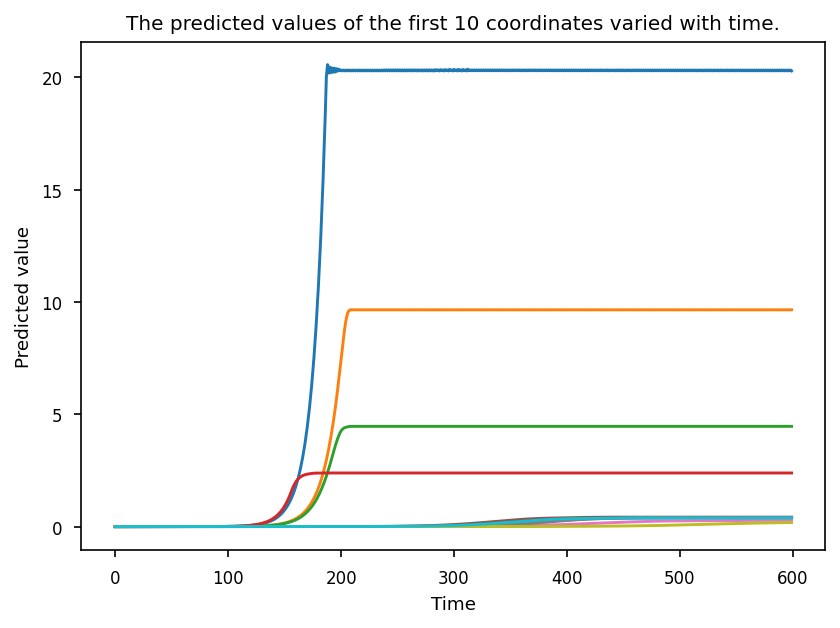

In [48]:
# prediction plot
point_num = 10
for i in range(point_num):
    plt.plot(pred[i])
# plt.yscale('log')
plt.ylabel('Predicted value')
plt.xlabel('Time')
plt.title(f'The predicted values of the first {point_num} coordinates varied with time.')

# plt.savefig(f'output/{setting}_pred.png')
plt.show()

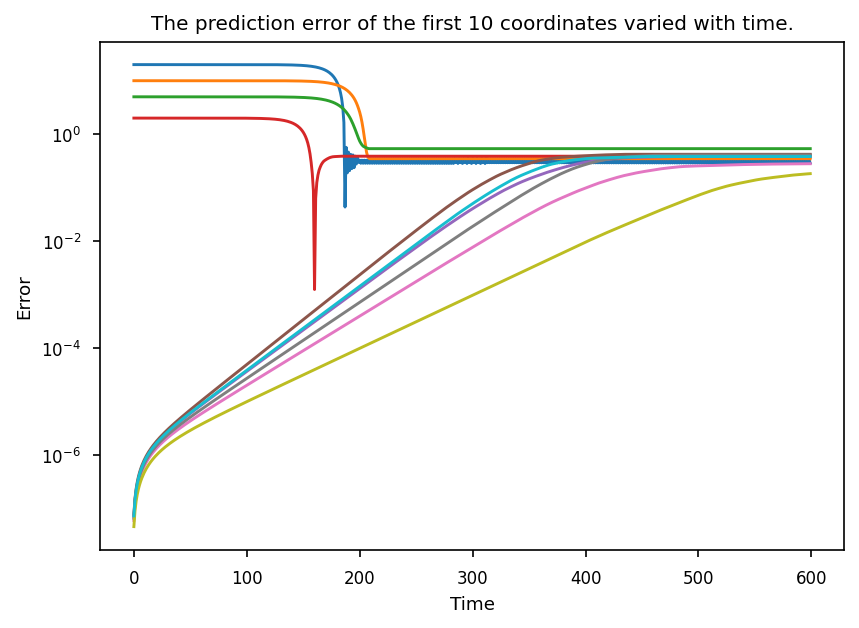

In [49]:
# error plot
for i in range(point_num):
    plt.plot(error[i])
plt.yscale('log')
plt.ylabel('Error')
plt.xlabel('Time')
plt.title(f'The prediction error of the first {point_num} coordinates varied with time.')

# plt.savefig(f'output/{setting}_error.png')
plt.show()

2.0403714307446053

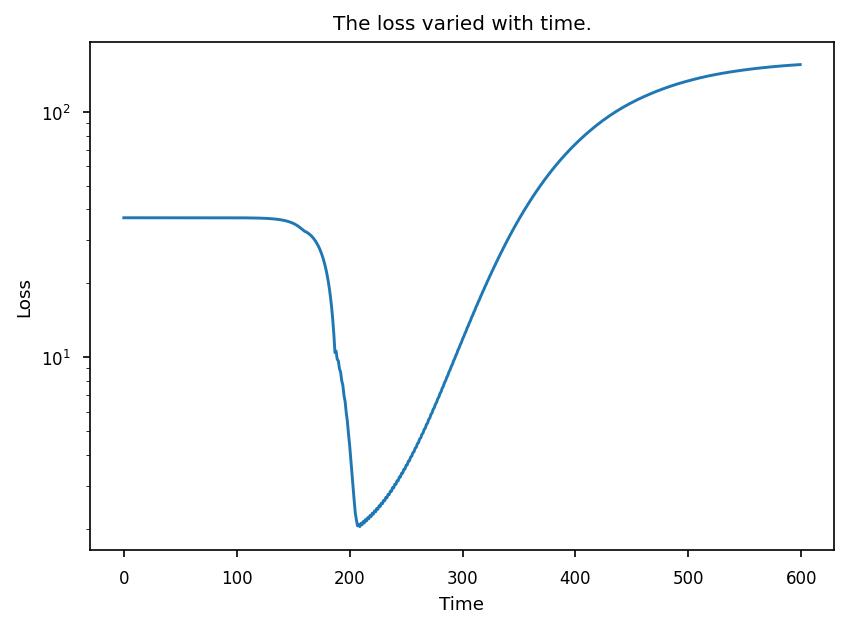

In [50]:


plt.plot(dists)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Time')
plt.title(f'The loss varied with time.')
# plt.savefig(f'output/{setting}_loss.png')
np.min(dists)

change initialization to np.ones
change K to 400
change p to 0.1

# TODO: compare other algorithms: runtime, l2 loss